# LAB 5 : TASK 1 - GENERATING THE 2-GRAM & 3-GRAM

Load the libraries

In [1]:
import pyspark
import string
import re
import time
import os
from pylab import *
from itertools import *
from pyspark.sql import SQLContext, Row

Create a regex for removing the punctuations from the text file

In [2]:
regex = re.compile('[%s]' % re.escape(string.punctuation))

Generate a pyspark Context

In [3]:
sc = pyspark.SparkContext()

Generate a SQL Context for our files

In [4]:
sqlContext = SQLContext(sc)

A function to read the string and generate the lemma dictionary

In [5]:
def buildLemmaDict(x):
    lemmas = x.split(",")
    
    lemmaWords = []
    
    for lemma in lemmas:
        if lemma!="":
            lemmaWords.append(lemma)
    
    lemmaDic = [(lemmas[0],list(set(lemmaWords)))]

    return(lemmaDic)

Read the lemmatizer CSV file to build the lemma dictionary

In [6]:
lemma_rdd = sc.textFile("./new_lemmatizer.csv")

Create a rdd from the above file to apply a common function "buildLemmaDict"

In [7]:
lemmaDictionary_rdd = (lemma_rdd.flatMap(lambda x : buildLemmaDict(x)))

Collect the rdd as a map to get the dictionary

In [8]:
lemmaDictionary = lemmaDictionary_rdd.collectAsMap()

A function to provide the lemmas by lookup from the lemma dictionary

In [9]:
def getLemmasList(word):
    
    cooccuranceList = []
    
    wordLemmaList = []
    
    if word in lemmaDictionary:
        wordLemmaList = wordLemmaList + lemmaDictionary.get(word)
    else : 
        wordLemmaList = [word]
        
    return wordLemmaList
        

Provide the location of the input file

In [10]:
path = "./input/"
subDirList = next(os.walk(path))[1]
print(subDirList)
subDirList = [int(x) for x in subDirList]
subDirList.sort()
subDirList = [path+str(x) for x in subDirList]
print(subDirList)

['1', '2']
['./input/1', './input/2']


# 2-Gram Generator

A for loop to generate the time duration and set up the path for output

We can specify a folder structure having different number of files.
And similarly we can define the output folder based on the input folder

Also showing the data in a tabular format.

**Following is just a test result we did using small amount of data.**

**Running the same code with better RAM provides much better performance.**

In [12]:
for dirPath in subDirList:
    outputPath = dirPath.replace("input","output2")

    start_time = time.time()
    
    data_rdd = sc.textFile(dirPath)

    test = data_rdd.filter(lambda y : y.strip()!="")\
        .map(lambda x : x.replace('\t','').lower().split(">"))\
        .map(lambda (x,y): (x,regex.sub('',y).strip().replace("j","i").replace("v","u").split(" ")))\
        .flatMap(lambda (x,y): [(pair,x[1:]+" |"+str(1+y.index(pair[0]))+"."+str(1+y.index(pair[1]))+"| ") for pair in combinations(y,2)])\
        .filter(lambda (x,y): x[0]!="" and x[1]!="")\
        .flatMap(lambda (x,y): [(lemma,y) for lemma in product(getLemmasList(x[0]),getLemmasList(x[1]))])\
        .reduceByKey(lambda x,y : x + ", "+y).sortByKey(True)
        
    
    print("Input Directory Path :" + dirPath)
    print("Ouput Directory Path :" + outputPath)
    print("Time taken for "+ dirPath[-1:] +" files %s" % (time.time() - start_time))
    
    test = test.map(lambda (x,y):("{"+x[0]+","+x[1]+"}",y))
    
    test.take(5)
    
    df = sqlContext.createDataFrame(test, ['n-gram (n =2)', 'Location'])
    
    df.show()
    
    df.coalesce(1).write.option("header", "true").csv(outputPath+"/result.csv")


Input Directory Path :./input/1
Ouput Directory Path :./output2/1
Time taken for 1 files 18.2540178299
+---------------+--------------------+
|  n-gram (n =2)|            Location|
+---------------+--------------------+
|{abundat,intus}|prud. epil. 4 |4.5| |
| {abundo,intus}|prud. epil. 4 |4.5| |
| {ad,congruens}|prud. epil. 22 |3...|
|   {ad,congruo}|prud. epil. 22 |3...|
|    {ad,erilem}|prud. epil. 22 |3...|
|    {ad,erilis}|prud. epil. 22 |3...|
|   {ad,leuamen}|prud. epil. 10 |2...|
|    {ad,pauper}|prud. epil. 10 |2...|
|  {ad,pauperum}|prud. epil. 10 |2...|
|    {ad,possum}|prud. epil. 10 |2...|
|    {ad,potens}|prud. epil. 10 |2...|
|  {ad,potentes}|prud. epil. 10 |2...|
|      {ad,usum}|prud. epil. 22 |3...|
|      {ad,usus}|prud. epil. 22 |3...|
|      {ad,utor}|prud. epil. 22 |3...|
|    {aer,defio}|prud. epil. 16 |2...|
|    {aer,defit}|prud. epil. 16 |2...|
|  {aer,expolio}|prud. epil. 16 |2...|
| {aer,expolita}|prud. epil. 16 |2...|
|   {aer,peluis}|prud. epil. 16 |2...|


# 3-Gram Generator

A for loop to generate the time duration and set up the path for output

We can specify a folder structure having different number of files.
And similarly we can define the output folder based on the input folder

Also showing the data in a tabular format.

**Following is just a test result we did using small amount of data.**

**Running the same code with better RAM provides much better performance.**

In [13]:
for dirPath in subDirList:
    outputPath = dirPath.replace("input","output3")

    start_time = time.time()
    
    data_rdd = sc.textFile(dirPath)

    test = data_rdd.filter(lambda y : y.strip()!="")\
        .map(lambda x : x.replace('\t','').lower().split(">"))\
        .map(lambda (x,y): (x,regex.sub('',y).strip().replace("j","i").replace("v","u").split(" ")))\
        .flatMap(lambda (x,y): [(pair,x[1:]+" |"+str(1+y.index(pair[0]))+"."+str(1+y.index(pair[1]))+"."+str(1+y.index(pair[2]))+"| ") for pair in combinations(y,3)])\
        .filter(lambda (x,y): x[0]!="" and x[1]!="" and x[2]!="")\
        .flatMap(lambda (x,y): [(lemma,y) for lemma in product(getLemmasList(x[0]),getLemmasList(x[1]),getLemmasList(x[2]))])\
        .reduceByKey(lambda x,y : x + ", "+y).sortByKey(True)
        
    print("Input Directory Path :" + dirPath)
    print("Ouput Directory Path :" + outputPath)
    print("Time taken for "+ dirPath[-1:] +" files %s" % (time.time() - start_time))
    
    test = test.map(lambda (x,y):("{"+x[0]+","+x[1]+","+x[2]+"}",y))
    
    test.take(5)
    
    df = sqlContext.createDataFrame(test, ['n-gram (n =3)', 'Location'])
    
    df.show()
    
    df.coalesce(1).write.option("header", "true").csv(outputPath+"/result.csv")


Input Directory Path :./input/1
Ouput Directory Path :./output3/1
Time taken for 1 files 15.4565629959
+--------------------+--------------------+
|       n-gram (n =3)|            Location|
+--------------------+--------------------+
|{ad,congruens,eri...|prud. epil. 22 |3...|
|{ad,congruens,eri...|prud. epil. 22 |3...|
| {ad,congruo,erilem}|prud. epil. 22 |3...|
| {ad,congruo,erilis}|prud. epil. 22 |3...|
| {ad,leuamen,pauper}|prud. epil. 10 |2...|
|{ad,leuamen,paupe...|prud. epil. 10 |2...|
| {ad,leuamen,possum}|prud. epil. 10 |2...|
| {ad,leuamen,potens}|prud. epil. 10 |2...|
|{ad,leuamen,poten...|prud. epil. 10 |2...|
|  {ad,pauper,possum}|prud. epil. 10 |2...|
|  {ad,pauper,potens}|prud. epil. 10 |2...|
|{ad,pauper,potentes}|prud. epil. 10 |2...|
|{ad,pauperum,possum}|prud. epil. 10 |2...|
|{ad,pauperum,potens}|prud. epil. 10 |2...|
|{ad,pauperum,pote...|prud. epil. 10 |2...|
| {ad,usum,congruens}|prud. epil. 22 |3...|
|   {ad,usum,congruo}|prud. epil. 22 |3...|
|    {ad,usum,eri

# Scale up Graph results for 2-Gram and 3-Gram

**The values used are the actual data we collected from various number of files **

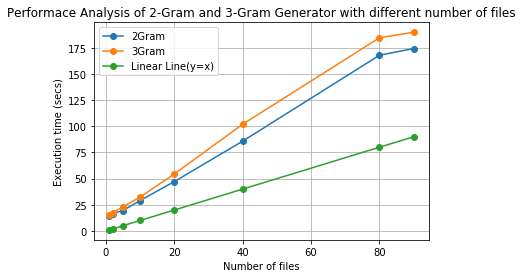

In [14]:
num_of_files = [1,2,5,10,20,40,80,90]
linear_line = [1,2,5,10,20,40,80,90]
execution_time_2_Gram = [14.7669999599,16.5650000572,19.5239999294,29.0959999561,47.1339998245,85.7990000248,167.852999926,174.265000105]
execution_time_3_Gram = [15.2109999657,17.493999958,23.0810000896,32.367000103,54.4680001736,101.955999851,184.548999786,189.816999912]

plot(num_of_files, execution_time_2_Gram, 'o-',num_of_files, execution_time_3_Gram, 'o-',num_of_files, linear_line, 'o-')

xlabel('Number of files')
ylabel('Execution time (secs)')
title('Performace Analysis of 2-Gram and 3-Gram Generator with different number of files')
legend(('2Gram','3Gram','Linear Line(y=x)'), loc='upper left')
grid(True)
savefig("performance.png")
show()

# Conclusion

We tested the above code with multiple files and found out that the time duration take for 2-Gram and 3-Gram both increases in a linear fashion for some
time. But after a certain number of files the code just stops which indicates an exponetial rise in the execution time for both the codes.
Hence we can say that there is a linear rise in execution time which booms exponetially later on.

The supporting plot generated above. The graph says the same story as mentioned in J. Lin & C. Dyer. Data intensive text 
processing with MapReduce book.

# References : 

1. http://spark.apache.org/docs/latest/programming-guide.html
2. http://stackoverflow.com/questions/31898964/how-to-write-the-resulting-rdd-to-a-csv-file-in-spark-python 